# CPSC 330 - Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 
### Associated lectures: [Lectures 7, 8](https://ubc-cs.github.io/cpsc330/README.html) 

**Due date: Friday, Feb 11, 2022 at 11:59pm**


## Imports 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

## Instructions 
<hr>
rubric={points:5}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2021W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

<br><br><br><br>

## Exercise 1: Implementing `DummyClassifier` 
<hr>
rubric={points:25}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: `fit` can return nothing, `predict` returns an array whose size is the number of examples, `predict_proba` returns an array whose size is the number of examples x 2, and `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [2]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """

    def __init__(self):
        """
            c_0 and c_1 are used in predict_proba
        """
        self.pred = None
        self.c_0 = None # Number of 0 in training data
        self.c_1 = None # Number of 1 in training data

    def fit(self, X, y):
        counts = pd.Series(y).value_counts()
        self.pred = counts.idxmax()
        self.c_0, self.c_1 = counts[0], counts[1]
        return counts

    def predict(self, X):
        return np.full(X.shape[0], self.pred)

    def predict_proba(self, X):
        prob_array = [
            (self.c_0)/(self.c_0 + self.c_1), 
            (self.c_1)/(self.c_0 + self.c_1)
        ]
        # return np.full(X.shape[0], prob_array)  # Replace with your code
        return np.array([prob_array for i in range(X.shape[0])])

    def score(self, X, y):
        predictions = np.full(X.shape[0], self.pred)
        bool_array = (predictions==y)
        return len(X[bool_array]) / len(bool_array)

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [3]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)


assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [4]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [5]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [6]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [7]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [8]:
# Boolean series
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [9]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [10]:
# Deterministically splits the whole dataset into training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

# A NLP preprocessing step that creates a count of all the words in the tweet, that are not part of the english stop word list
countvec = CountVectorizer(stop_words="english")

# Logistic Regression where we give it a maximum of 1000 iteratives for the solver to converge.
lr = LogisticRegression(max_iter=1000)

# A pipeline that will preprocess the data with the CountVectorizer then apply a logistic regression.
pipe = make_pipeline(countvec, lr)


# A dataframe of the training and cross-validation scores for every fold of a 5 fold cross validation
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# The average of each category of cross_val_results, avg fit time, score time, cross_validation score, and train_score
cross_val_results.mean()


fit_time       3.400964
score_time     0.199343
test_score     0.898444
train_score    0.967952
dtype: float64

<br><br>

#### 2(b) Cross-validation fold sub-scores
rubric={points:5}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores. 
- Are the 5 scores close to each other or spread far apart? (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?

In [11]:
cross_val_results["test_score"]

0    0.895587
1    0.898047
2    0.896817
3    0.897893
4    0.903876
Name: test_score, dtype: float64

### Answer

They are pretty close to eachother, only differing by ~1%.
Note at the time of writing, my results were (0.895587,89804,.8968,0.8979,0.90)

<br><br>

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [28]:
dummy_clf = DummyClassifier(strategy="prior")
dummy_clf.fit(X_train, y_train)
acc = "{:.2f}".format(dummy_clf.score(X_test, y_test))
print(f"The dummy classifer has an accuracy of: {acc} on unseen data")

The dummy classifer has an accuracy of: 0.74 on unseen data


### Answer
The logistic regression seems to have done something useful as the accuracy went from 0.74 (dummy) to 0.90 (lr). It isn't necessary to use CountVectorizer here because we're not looking at the features with a dummy classifier.

<br><br>

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [29]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer', CountVectorizer(stop_words='english')),
                ('logisticregression',
                 LogisticRegression(C=31.622776601683793, max_iter=1000))])

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

In [60]:
# True means viral
test_probs = pipe.predict_proba(X_test)
highest_prob_idx, highest_prob = (pd.Series(test_probs[:,1]).idxmax(), pd.Series(test_probs[:,1]).max())
highest_twt = X_test.iloc[highest_prob_idx]

print(f"Tweet: {highest_twt} \n\nProbability Score: {highest_prob}")

Tweet: Wow! FBI made 11 payments to Fake Dossier’s discredited author, Trump hater Christopher Steele. @ OANN @ JudicialWatch The Witch Hunt has been a total fraud on your President and the American people! It was brought to you by Dirty Cops, Crooked Hillary and the DNC. 

Probability Score: 0.9999999999999958


<br><br>

#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:


In [61]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display the 5 words with the highest coefficients and the 5 words with the smallest coefficients.

In [95]:
coef_tbl = pd.DataFrame({
    "Features": vec_from_pipe.vocabulary_.keys(),
    "Coefficient": np.abs(lr_from_pipe.coef_[0])
}).sort_values(by = "Coefficient", ascending=False)
highest_coef = coef_tbl.head(5)
lowest_coef = coef_tbl.tail(5)

print("The features with the highest coefficients are:")
print(highest_coef)
print("\n \n \n ")
print("The features with the lowest coefficients are:")
print(lowest_coef)

The features with the highest coefficients are:
             Features  Coefficient
33017           erase    10.557349
22556    damnitjustin     9.044305
1294               ny     8.871122
370         commander     8.676417
755    mzinvestigator     8.149417

 
 
 
The features with the lowest coefficients are:
            Features  Coefficient
2441         rallies     0.000016
27275           ashk     0.000016
23339     6am9n6px8i     0.000012
25700  derrickfawley     0.000009
38578            aei     0.000002


<br><br>

#### 2(f)
rubric={points:10}

scikit-learn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. Here, your task is to "manually" (without `Pipeline` and without `cross_validate` or `cross_val_score`) compute logistic regression's validation score on one fold (that is, train on 80% and validate on 20%) of the training data. 

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split):

In [96]:
countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)

Meta-comment: you might be wondering why we're going into "implementation" here if this course is about _applied_ ML. In CPSC 340, we would go all the way down into `LogisticRegression` and understand how `fit` works, line by line. Here we're not going into that at all, but I still think this type of question (and Exercise 1) is a useful middle ground. I do want you to know what is going on in `Pipeline` and in `cross_validate` even if we don't cover the details of `fit`. To get into logistic regression's `fit` requires a bunch of math; here, we're keeping it more conceptual and avoiding all those prerequisites.

In [119]:
cv_X_train, cv_X_valid, cv_y_train, cv_y_valid = train_test_split(X_train, y_train, test_size=0.20, train_size=0.80, random_state=1)

# Preprocessing steps
cv_X_train = countvec.fit_transform(cv_X_train)
cv_X_valid = countvec.transform(cv_X_valid)

# Training model
lr.fit(X = cv_X_train, y = cv_y_train)

# Computing validation score
validation_score = lr.score(cv_X_valid, cv_y_valid)

print(f"The validation score of 1 fold: {round(validation_score, 2)}")

The validation score of 1 fold: 0.89


<br><br><br><br>

## Exercise 3: hyperparameter optimization
<hr>

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. Based on the plot/output, what value of `max_features` seems best? Briefly explain.

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

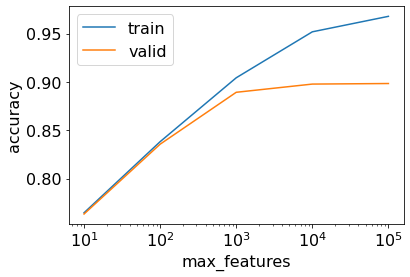

In [120]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [121]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.764701,0.763425
1,100,0.838270,0.835671
2,1000,0.904380,0.889371
3,10000,0.951936,0.897860
4,100000,0.967952,0.898444


**max_features = 1000 seems to be the best one.** It's validation accuracy is only ~2% smaller than the highest and the training accuracy is only ~1% better than the validation accuracy which means there's little overfitting occuring. The problem with max_features=10,000 and 100,000 is that the training accuracy and validationa accuracy significantly differ which means there's a lot of overfitting occuring.

<br><br>

#### 3(b)
rubric={points:4}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. Based on the plot, what value of `C` seems best?

Note: the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

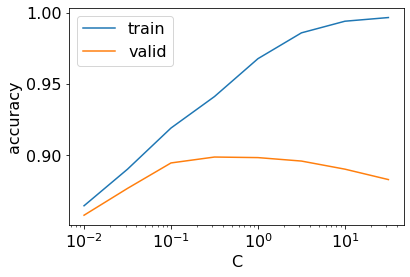

In [122]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-2, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [123]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.010000,0.864612,0.857969
1,0.031623,0.890316,0.876822
2,0.100000,0.919227,0.894692
3,0.316228,0.941333,0.898844
4,1.000000,0.967952,0.898444
5,3.162278,0.986091,0.896014
6,10.000000,0.994256,0.890324
7,31.622777,0.996840,0.883004


C $\in$ [0.1, 31.622] yield similar validation accuracies. 0.31-31.622 look like they're overfitting, since training score gets very high. C = 0.1 would be the best hyperparameter**

<br><br>

#### 3(c)
rubric={points:12}

- Using `GridSearchCV`, jointly optimize `max_features` and `C` across all the combinations of values we tried above. 
  - Note: the code might be a bit slow here. 
  - Setting `n_jobs=-1` should speed it up if you have a multi-core processor.
  - You can reduce the number of folds (e.g. `cv=2`) to speed it up if necessary.
- What are the best values of `max_features` and `C` according to your grid search?
- Do these best values agree with what you found in parts (a) and (b)?
- Generally speaking, _should_ these values agree with what you found in parts (a) and (b)? Explain.

In [133]:
param_grid = {
    "countvectorizer__max_features": max_features,
    "logisticregression__C": C_vals
}

pipe = make_pipeline(
    CountVectorizer(stop_words="english", max_features=None),
    LogisticRegression(max_iter=1000),
)

grid_search = GridSearchCV(
    pipe, param_grid, cv=2, n_jobs=-1, return_train_score=True
)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(stop_words='english')),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'countvectorizer__max_features': [10, 100, 1000, 10000,
                                                           100000],
                         'logisticregression__C': array([1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01])},
             return_train_score=True)

In [138]:
grid_search.best_params_

{'countvectorizer__max_features': 10000,
 'logisticregression__C': 0.31622776601683794}

In [ ]:
#TODO Check if we're just looking for max validation score.

#### 3(d)
rubric={points:5}

- Evaluate your final model on the test set. 
- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

<br><br><br><br>

## Exercise 4: Very short answer questions
rubric={points:10}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?
3. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
4. What are two advantages of using sklearn `Pipeline`s? 
5. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?

1. You're no longer transforming based on the words on the training data. 
2. If you model has some sort of knowledge of the testing data, you'll no longer have a metric of how well your model performs on unknown data. It won't necessarily give you a worse classifier, but you'd just not be able to tell if they're good/bad.
3. I would choose predict_proba because it gives you more information than predict. If you wanted to know predict you would just look at whichever probability is highest.
4. Less likely to make mistakes by leaking information between training/testing. Clearly outlines the preprocessing steps/models that are being used all in 1 section of your code.
5. Faster when compared to GridSearchCV, especially when lots of hyperparameters. Works better when some parameters are more important than others. 


In [19]:
# TODO Exercise 4

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 